In [29]:
root = '../input/car-object-detection/data/training_images/'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/car-object-detection/data/sample_submission.csv
/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv
/kaggle/input/car-object-detection/data/testing_images/vid_5_26420.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_31520.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29420.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_31720.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_26560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_27840.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_28560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_28360.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_25240.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29020.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_30720.jpg
/kaggle/

# Importing Libraries

In [30]:
import numpy as np 
import pandas as pd 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches
import random
import cv2
import torch
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as tt
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
import torchinfo
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Introduction

#### In this notebook, we will be attempting to predict the location of the car in the image provided. 
#### We will be given the four corner coordinates of the car and our job would be to predict them.
#### Let's first visualize to see what it looks like.

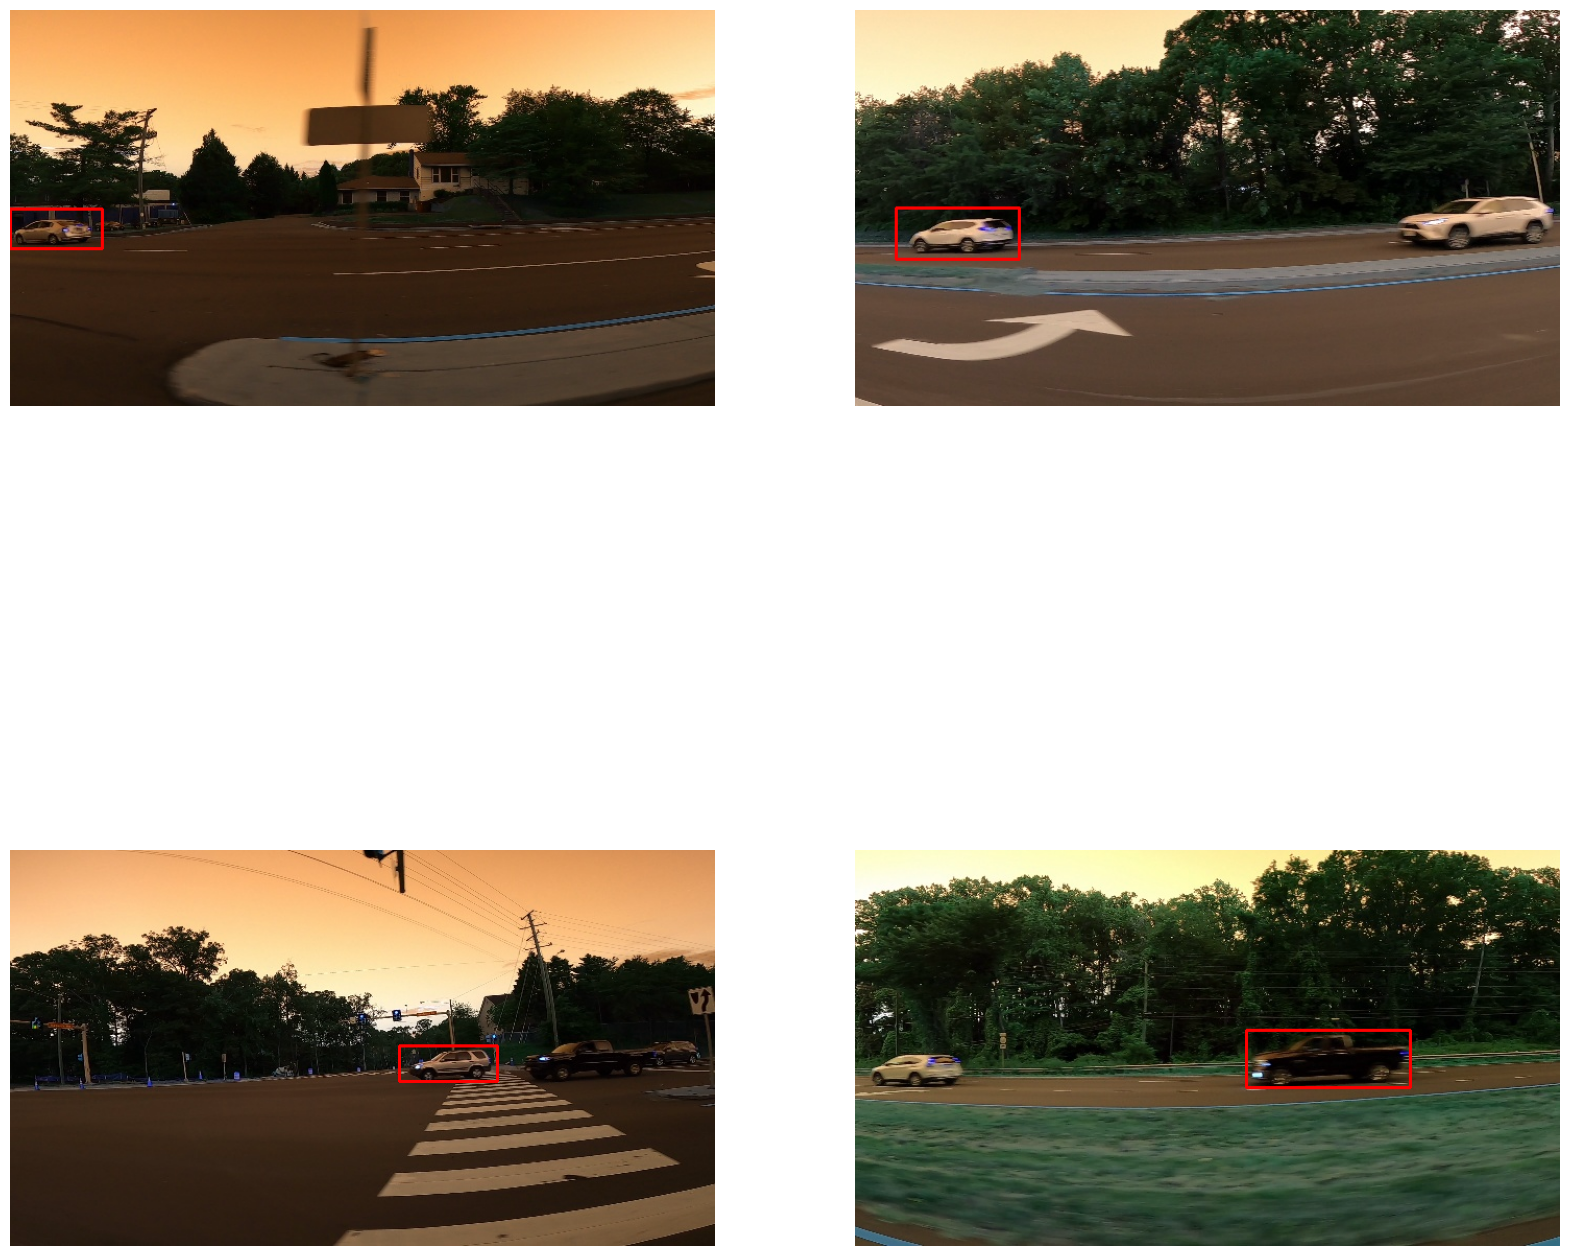

In [31]:
train_df = pd.read_csv('/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
fig = plt.figure(figsize=(20,20))
random_list = random.sample(range(0, train_df.shape[0]), 4)

for i, idx in enumerate(random_list):
    x1, x2, y1, y2 = train_df.iloc[idx,:]['xmin'], train_df.iloc[idx,:]['xmax'], train_df.iloc[idx,:]['ymin'], train_df.iloc[idx,:]['ymax']
    
    image_path = cv2.imread(glob.glob(root + train_df.iloc[idx,:]['image'])[0])
    cv2.rectangle(image_path, (int(x1), int(y1)), (int(x2), int(y2)),(255, 0, 0), 2)
    
    fig.add_subplot(2, 2, i+1)
    plt.imshow(image_path)
    plt.axis('off');

#### As we can see, we are trying to predict certain car's location in every single image.
#### As with any deep learning tasks, let's go ahead with preparing our data.

# Data Preparation

In [32]:
scaler = MinMaxScaler()
train_df[['xmin', 'ymin', 'xmax', 'ymax']] = scaler.fit_transform(train_df[['xmin', 'ymin', 'xmax', 'ymax']])
train_df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,0.435936,0.647541,0.462081,0.226398
1,vid_4_10000.jpg,0.023503,0.647541,0.141748,0.346439
2,vid_4_10040.jpg,0.370735,0.475410,0.514966,0.346439
3,vid_4_10020.jpg,0.769522,0.401639,0.928983,0.301979
4,vid_4_10060.jpg,0.025777,0.639344,0.160635,0.364223
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,0.836707,0.031939,0.344559
555,vid_4_9880.jpg,0.511290,0.135473,0.784791,0.474327
556,vid_4_9900.jpg,0.000000,0.333469,0.174905,0.371407
557,vid_4_9960.jpg,0.755489,0.399467,0.908745,0.277437


In [33]:
train_df.iloc[-32,:]

image    vid_4_9560.jpg
xmin           0.329668
ymin           0.787208
xmax           0.384791
ymax           0.255063
Name: 527, dtype: object

#### Now this is an important step. 
#### You can go ahead and try training the model without scaling the coordinates.
#### If you do so, you will run into the problem of exploding gradients as the target values are just too large.
#### Therefore, we would need to shrink them down beforehand.

In [34]:
height, width = 224, 224

# Create training transform with TrivialAugment
train_transform_trivial_augment = tt.Compose([
    
    tt.Resize((height, width)),
    tt.TrivialAugmentWide(num_magnitude_bins=31),
    tt.ToTensor(),
    tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create testing transform (no data augmentation)
test_transform = tt.Compose([
    tt.Resize((height, width)),
    tt.ToTensor(),
    tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

#### Let's create our custom dataset.

In [35]:
class VehicleDetection(Dataset):
    def __init__(self, dataframe, transform):
        self.df = dataframe
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        x1, x2, y1, y2 = self.df.iloc[idx,:]['xmin'], self.df.iloc[idx,:]['xmax'], self.df.iloc[idx,:]['ymin'], self.df.iloc[idx,:]['ymax']
    
        image_list = glob.glob(root + self.df.iloc[idx,:]['image'])[0]
        
        if type(image_list) == str:
            image_list = [image_list]
            
        x1 = torch.tensor(x1, dtype=torch.float)
        x2 = torch.tensor(x2, dtype=torch.float)
        y1 = torch.tensor(y1, dtype=torch.float)
        y2 = torch.tensor(y2, dtype=torch.float)
        
        for image in image_list:
            img = Image.open(image)
            
        return self.transform(img), torch.tensor([x1, y1, x2, y2])

In [36]:
train_data_custom = VehicleDetection(train_df.iloc[:512, :], train_transform_trivial_augment)
test_data_custom = VehicleDetection(train_df.iloc[-32:, :], test_transform)

In [37]:
print(f"We have {len(train_data_custom)} training datapoints and {len(test_data_custom)} testing datapoints")

We have 512 training datapoints and 32 testing datapoints


#### Let's make our custom DataLoaders now.

In [38]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=2, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=32, 
                                    num_workers=2, 
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f4b9ff6c250>,
 <torch.utils.data.dataloader.DataLoader at 0x7f4b9ff6c210>)

#### Let's check whether they are working correctly.

In [39]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32, 4])


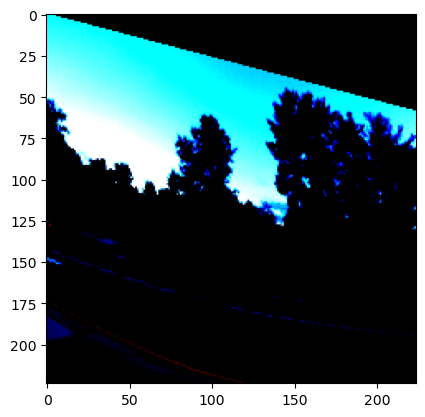

In [40]:
plt.imshow(img_custom[0].permute(1, 2, 0))

#### Sweet! Seems like it is working as intended!

# Modeling

#### Let's try to build our own model.
#### Although there is a high chance it won't perform superbly due to the limited number of examples, let's give it a go!

In [50]:
class Basic_CNN(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_shape, 3, 1, 1), # hidden * 224 * 224
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 224 * 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # hidden * 112 * 112 
                         stride=2)
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 112 * 112 
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 112 * 112 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # hidden * 56 * 56 
                         stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_shape * 56 * 56, 1024),
            nn.Linear(1024, 240),
            nn.Linear(240, 120),
            nn.Linear(120, 4)
        )
        
    def forward(self, x):
        return self.classifier(self.conv_2(self.conv_1(x)))
    
torch.manual_seed(42)
basic_model = Basic_CNN(3,32,4)
basic_model.to(device)

torchinfo.summary(basic_model)

Layer (type:depth-idx)                   Param #
Basic_CNN                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       9,248
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       9,248
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       9,248
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      102,761,472
│    └─Linear: 2-13                      246,000
│    └─Linear: 2-14                      28,920
│    └─Linear: 2-15                      484
Total params: 103,065,516
Trainable params: 103,065,516
Non-trainable params: 0

#### Let's try training it.

In [51]:
# Setup loss function and optimizer
model = basic_model
lf = nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

epochs = 50

train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    train_loss = 0
    
    for batch, (X,y) in enumerate(train_dataloader_custom):

        X = X.to(device)
        y = y.to(device)
        model.train()
        
        # Forward
        y_pred = model(X)
        
        # Calculate loss
        loss = lf(y_pred, y)
        train_loss += loss
        
        # Zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss)
    
    test_loss, test_acc= 0, 0
    model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader_custom):
            
            X = X.to(device)
            y = y.to(device)
            
            # Forward
            test_pred = model(X)
            
            # Calculate loss 
            test_loss += lf(test_pred, y)
            
        test_loss /= len(test_dataloader_custom)
        test_loss_arr.append(test_loss)
        
    print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}\n")


Epoch: 0 | Train loss: 0.28367 | Test loss: 0.23002


Epoch: 1 | Train loss: 0.22677 | Test loss: 0.17236


Epoch: 2 | Train loss: 0.16541 | Test loss: 0.11286


Epoch: 3 | Train loss: 0.10781 | Test loss: 0.07172


Epoch: 4 | Train loss: 0.07811 | Test loss: 0.05872


Epoch: 5 | Train loss: 0.07270 | Test loss: 0.05672


Epoch: 6 | Train loss: 0.06892 | Test loss: 0.05681


Epoch: 7 | Train loss: 0.07027 | Test loss: 0.05676


Epoch: 8 | Train loss: 0.07034 | Test loss: 0.05679


Epoch: 9 | Train loss: 0.07007 | Test loss: 0.05672


Epoch: 10 | Train loss: 0.07030 | Test loss: 0.05690


Epoch: 11 | Train loss: 0.06891 | Test loss: 0.05677


Epoch: 12 | Train loss: 0.06915 | Test loss: 0.05667


Epoch: 13 | Train loss: 0.06858 | Test loss: 0.05669


Epoch: 14 | Train loss: 0.06969 | Test loss: 0.05679


Epoch: 15 | Train loss: 0.06871 | Test loss: 0.05668


Epoch: 16 | Train loss: 0.06816 | Test loss: 0.05668


Epoch: 17 | Train loss: 0.06784 | Test loss: 0.05686


Epoch: 18 | Train l

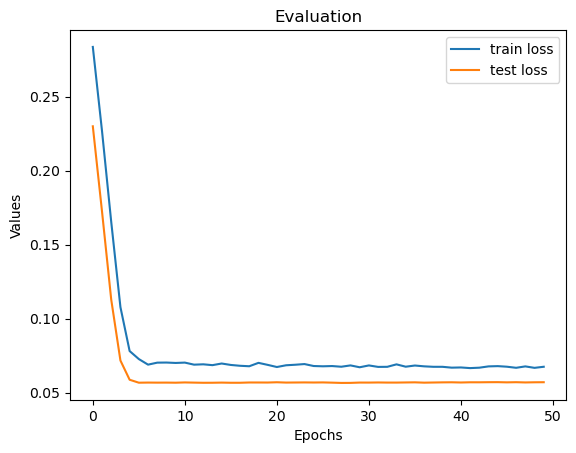

In [52]:
train_loss_cpu = []
test_loss_cpu = []

for i in train_loss_arr:
    train_loss_cpu.append(i.cpu().detach().numpy())
    
for i in test_loss_arr:
    test_loss_cpu.append(i.cpu().detach())

plt.plot([i for i in range(epochs)], train_loss_cpu, label='train loss')
plt.plot([i for i in range(epochs)], test_loss_cpu, label='test loss')
plt.title('Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend();

#### Cool! I believe at least we got somewhere.
#### The loss values definitely fell and it feels like it could have sustained more epochs before running into the problem of overfitting.
#### However, as with every deep learning task, let us take a look at the actual predictions of the model.

# Evaluation

#### Let's see how the original image looks like with the annotated box.

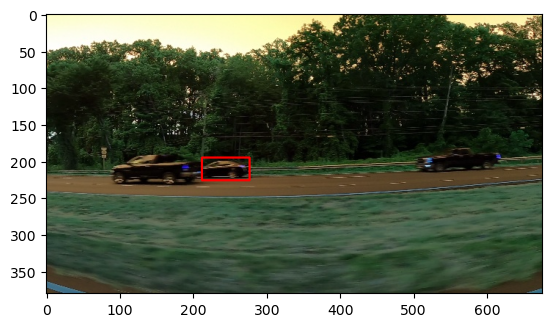

In [44]:
model.eval() 
with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader_custom):
            
        X = X.to(device)
        y = y.to(device)
            
        # Forward
        test_pred = model(X)

idx = 0

test_pred_0 = test_pred[idx]
y_0 = y[idx]
X_0 = X[idx]

actual_corr = scaler.inverse_transform([y_0.cpu().numpy()])
predicted_corr = scaler.inverse_transform([test_pred_0.cpu().numpy()])

image_path = cv2.imread(glob.glob(root + train_df.iloc[-32+idx,:]['image'])[0])
corr = actual_corr
cv2.rectangle(image_path, (int(corr[0][0]), int(corr[0][1])), (int(corr[0][2]), int(corr[0][3])),(255, 0, 0), 2)
plt.imshow(image_path)

#### Let's see what our model predicted for this image.

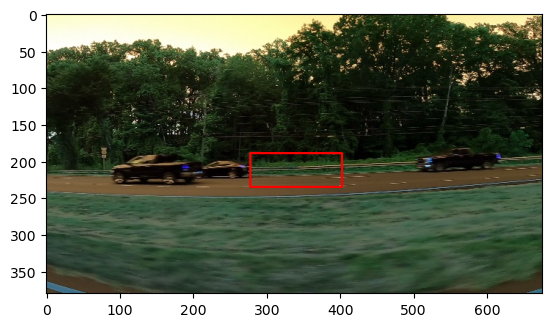

In [45]:
image_path = cv2.imread(glob.glob(root + train_df.iloc[-32+idx,:]['image'])[0])
corr = predicted_corr
cv2.rectangle(image_path, (int(corr[0][0]), int(corr[0][1])), (int(corr[0][2]), int(corr[0][3])),(255, 0, 0), 2)
plt.imshow(image_path)

#### Well... that is a shame.
#### Let's check out other images.

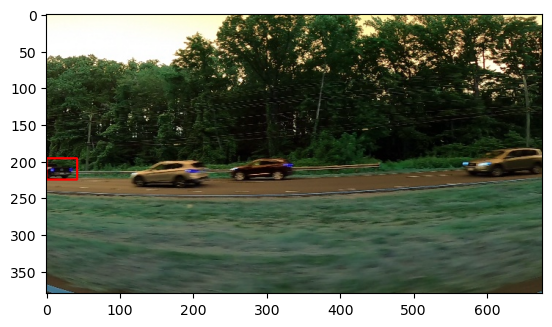

In [48]:
idx = 10

test_pred_0 = test_pred[idx]
y_0 = y[idx]
X_0 = X[idx]

actual_corr = scaler.inverse_transform([y_0.cpu().numpy()])
predicted_corr = scaler.inverse_transform([test_pred_0.cpu().numpy()])

image_path = cv2.imread(glob.glob(root + train_df.iloc[-32+idx,:]['image'])[0])
corr = actual_corr
cv2.rectangle(image_path, (int(corr[0][0]), int(corr[0][1])), (int(corr[0][2]), int(corr[0][3])),(255, 0, 0), 2)
plt.imshow(image_path)

#### How did our model predict for this?

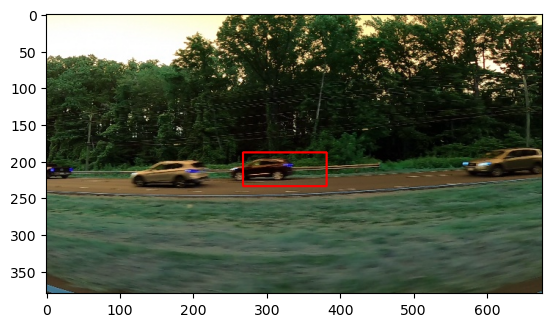

In [49]:
image_path = cv2.imread(glob.glob(root + train_df.iloc[-32+idx,:]['image'])[0])
corr = predicted_corr
cv2.rectangle(image_path, (int(corr[0][0]), int(corr[0][1])), (int(corr[0][2]), int(corr[0][3])),(255, 0, 0), 2)
plt.imshow(image_path)

# Conclusion

#### As we can see, our model performed terribly even though the loss seemed very minute.
#### There is a lot of room for improvement here and I am sure this is not how a object detection model should look like.
#### Our training and testing error doesn't seem to be decreasing any further.
#### From that, we can assume that our model is not complex enough and is worsened by a lack of data.
#### There are a lot more established models out there such as the YOLO algorithm and I suggest you to go read up about that.